Overall error is  0.16380650204277228


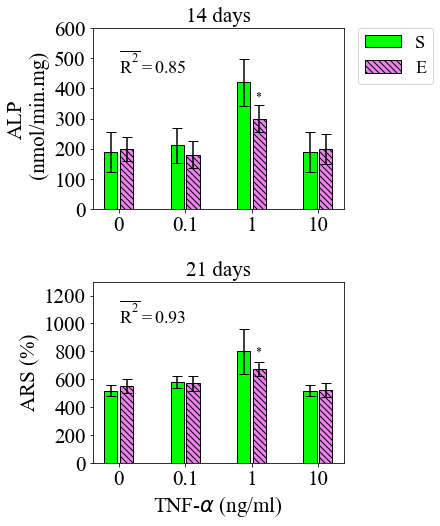

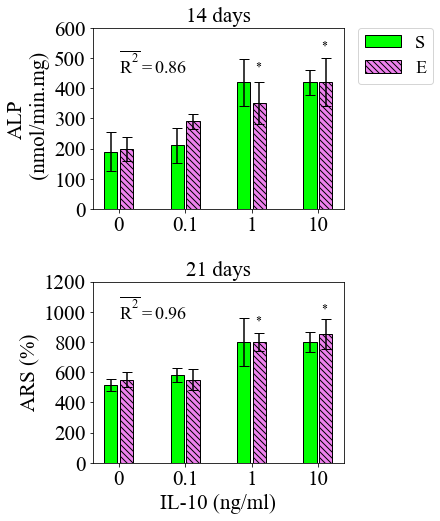

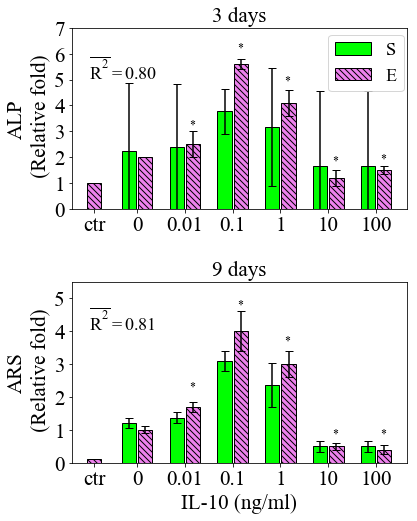

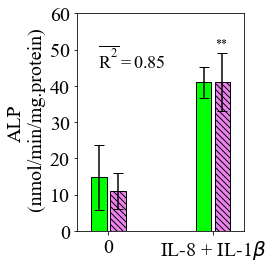

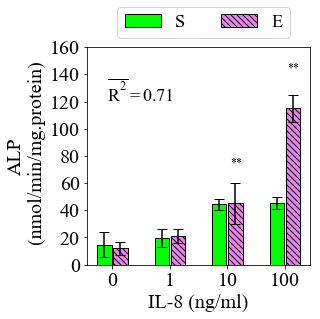

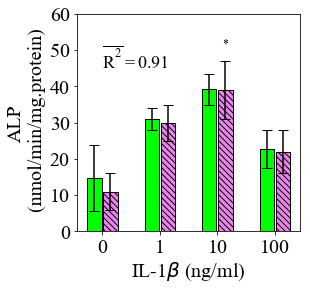

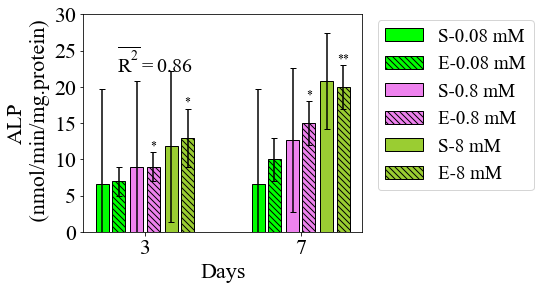

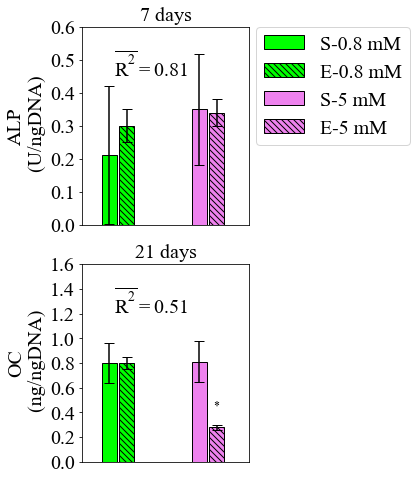

In [2]:
import sys
import pathlib
import os
import importlib
%config Completer.use_jedi = False
current_file = '/Users/matin/Downloads/testProjs/MSC_M/scripts'
dir_to_dirs = os.path.join(current_file,'..')
sys.path.insert(0,dir_to_dirs)
from dirs import dir_to_MSC_osteogenesis
sys.path.insert(0,dir_to_MSC_osteogenesis)
import MSC_osteogenesis 
import json
import plots
import parameters
import numpy as np 
importlib.reload(plots)
importlib.reload(parameters)
importlib.reload(MSC_osteogenesis)
def results_file(study):
	file = None
	if study == 'Qiao_2021_Mg':
		file = 'inferred_params_0_200.json'
	elif study == 'Ber_2016':
		file = 'inferred_params_0_120.json'
	elif study == 'Chen_2018':
		file = 'inferred_params_0_200.json'
	elif study == 'Valles_2020':
		file = 'inferred_params_0_200.json'
	elif study == 'Qiao_2021_ILs':
		file = 'inferred_params_0_400.json'
	elif study == 'All':
		file = 'inferred_params_0_200.json'
		
	return file

class settings:
# 	study = 'Qiao_2021_Mg'
# 	study = 'Qiao_2021_ILs'
# 	study = 'Ber_2016'
# 	study = 'Chen_2018'
# 	study = 'Valles_2020'
	study = 'All'
	# results_folder = os.path.join(dir_to_dirs,'raw_results',study)
	# results_file = os.path.join(results_folder,results_file(study))
	# output_folder = results_folder
	
	# results_file = os.path.join(dir_to_dirs,'results','inferred_params.json')
	# output_folder = os.path.join(dir_to_dirs,'results')
	
	results_folder = os.path.join(dir_to_dirs,'results',study,'batch_calibration_selected')
	results_file = os.path.join(results_folder,'inferred_params_1.json')
	output_folder = os.path.join(dir_to_dirs,'results',study)

	detailed_error_file = os.path.join(dir_to_dirs,'results','detailed_errors.json')
		
def process_detailed_errors(detailed_errors_list):#originally, detailed_errors are a vector of all items. Here, we find max error for each measurment item/day
    typical_errors_template = detailed_errors_list[0]
    processed_detailed_errors = {}
    item_ii = 0
    for detailed_errors in detailed_errors_list:
        for study,study_errors in detailed_errors.items():
            if item_ii == 0:
                processed_detailed_errors[study] = {}
            for ID, ID_errors in study_errors.items():
                if item_ii == 0:
                    processed_detailed_errors[study][ID] = {}
                for target, target_errors in ID_errors.items():
                    if item_ii == 0:
                        processed_detailed_errors[study][ID][target] = []
                    for i in range(len(target_errors)):
                        new_error = target_errors[i]
                        if item_ii == 0:
                            processed_detailed_errors[study][ID][target].append(error)
                        else:
                            previous_max = processed_detailed_errors[study][ID][target][i]
                            if new_error > previous_max:
                                processed_detailed_errors[study][ID][target][i] =new_error
                                
#         print('\n',processed_detailed_errors)
#         if item_ii ==5:
#             sys.exit(2)
        item_ii+=1  
    return processed_detailed_errors

        
def rearrange_errors(errors,targets): # by default, errors are categorized according to IDs. This arranges them according to targets
#     print(errors)
#     print(targets)
	target_errors = {}
	for target in targets:
		target_error_list = []
		for ID,ID_error in errors.items():
			target_error_list.append(ID_error[target])
		target_errors[target] = np.mean(target_error_list)
	return target_errors
	
##/ run test simultions and plot
with open(os.path.join(settings.results_file)) as file:
	inferred_params = json.load(file)
# inferred_params['a_late_diff_inhib'] = 10
all_studies_flag = False
obs,_ = parameters.specifications(settings.study)

obj = MSC_osteogenesis.MSC_model(fixed_params=parameters.fixed_params,free_params = inferred_params,observations=obs, debug=False)
simulation_results = obj.simulate_studies()
study_errors = obj.cost_studies(simulation_results)

error = obj.run()

print('Overall error is ',error)

#// load the detailed errors and process them
with open(settings.detailed_error_file) as file:
    detailed_errors = json.load(file)
processed_detailed_errors = process_detailed_errors(detailed_errors[settings.study])

for study in obs['studies']:
    targets = list(obs[study]['measurement_scheme'].keys())
    study_error = rearrange_errors(study_errors[study],targets)
    if study == 'Qiao_2021_Mg' or study == 'Ber_2016':
            plot_obj = plots.Plot_bar_2(study=study,observations=obs,errors=study_error,destination = settings.output_folder)
    else:
            plot_obj = plots.Plot_bar(study=study,observations=obs,errors=study_error,destination = settings.output_folder)
    plot_obj.plot(simulation_results = simulation_results[study],processed_detailed_errors=processed_detailed_errors[study])
